# Premier pas vers l’industrialisation avec les pipelines scikit

Lino Galiana  
2024-09-23

Ce chapitre présente la première application
d’une journée de cours que j’ai
donné à l’Université Dauphine dans le cadre
des *PSL Data Week*.

<details>
<summary>

Dérouler les _slides_ associées ci-dessous ou [cliquer ici](https://linogaliana.github.io/dauphine-week-data/#/title-slide)
pour les afficher en plein écran.

</summary>


<div class="sourceCode" id="cb1"><pre class="sourceCode yaml code-with-copy"><code class="sourceCode yaml"></code><button title="Copy to Clipboard" class="code-copy-button"><i class="bi"></i></button></pre><iframe class="sourceCode yaml code-with-copy" src="https://linogaliana.github.io/dauphine-week-data/#/title-slide"></iframe></div>

</details>

Pour lire les données de manière efficace, nous
proposons d’utiliser le *package* `duckdb`.
Pour l’installer, voici la commande :

In [1]:
!pip install duckdb

# 1. Pourquoi utiliser les *pipelines* ?

## 1.1 Définitions préalables

Ce chapitre nous amènera à explorer plusieurs écosystèmes, pour lesquels on retrouve quelques buzz-words dont voici les définitions :

| Terme    | Définition                                                                                                                                                                           |
|---------------------------|---------------------------------------------|
| *DevOps* | Mouvement en ingénierie informatique et une pratique technique visant à l’unification du développement logiciel (dev) et de l’administration des infrastructures informatiques (ops) |
| *MLOps*  | Ensemble de pratiques qui vise à déployer et maintenir des modèles de machine learning en production de manière fiable et efficace                                                   |

Ce chapitre fera des références régulières au cours
de 3e année de l’ENSAE
[*“Mise en production de projets data science”*](https://ensae-reproductibilite.github.io/website/).

## 1.2 Objectif

Les chapitres précédents ont permis de montrer des bouts de code
épars pour entraîner des modèles ou faire du *preprocessing*.
Cette démarche est intéressante pour tâtonner mais risque d’être coûteuse
ultérieurement s’il est nécessaire d’ajouter une étape de *preprocessing*
ou de changer d’algorithme.

Les *pipelines* sont pensés pour simplifier la mise en production
ultérieure d’un modèle de *machine learning*.
Ils sont au coeur de la démarche de *MLOps* qui est
présentée
dans le cours de 3e année de l’ENSAE
de [*“Mise en production de projets data science”*](https://ensae-reproductibilite.github.io/website/),
qui vise à simplifier la mise en oeuvre opérationnelle de
projets utilisant des techniques de *machine learning*.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


## 1.3 Les *pipelines* `Scikit`

Heureusement, `Scikit` propose un excellent outil pour proposer un cadre
général pour créer une chaîne de production *machine learning*. Il
s’agit des
[*pipelines*](https://scikit-learn.org/stable/modules/compose.html).
Ils présentent de nombreux intérêts, parmi lesquels :

-   Ils sont très **pratiques** et **lisibles**. On rentre des données en entrée, on n’appelle qu’une seule fois les méthodes `fit` et `predict` ce qui permet de s’assurer une gestion cohérente des transformations de variables, par exemple après l’appel d’un `StandardScaler` ;
-   La **modularité** rend aisée la mise à jour d’un pipeline et renforce la capacité à le réutiliser ;
-   Ils permettent de facilement chercher les hyperparamètres d’un modèle. Sans *pipeline*, écrire un code qui fait du *tuning* d’hyperparamètres peut être pénible. Avec les *pipelines*, c’est une ligne de code ;
-   La **sécurité** d’être certain que les étapes de preprocessing sont bien appliquées aux jeux de données désirés avant l’estimation.

<div class="alert alert-warning" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Hint</h3>

Un des intérêts des *pipelines* scikit est qu’ils fonctionnent aussi avec
des méthodes qui ne sont pas issues de `scikit`.

Il est possible d’introduire un modèle de réseau de neurone `Keras` dans
un pipeline `scikit`.
Pour introduire un modèle économétrique `statsmodels`
c’est un peu plus coûteux mais nous allons proposer des exemples
qui peuvent servir de modèle et qui montrent que c’est faisable
sans trop de difficulté.

</div>

# 2. Comment créer un *pipeline*

Un *pipeline* est un enchaînement d’opérations qu’on code en enchainant
des pairs *(clé, valeur)* :

-   la clé est le nom du pipeline, cela peut être utile lorsqu’on va
    représenter le *pipeline* sous forme de diagramme acyclique (visualisation DAG)
    ou qu’on veut afficher des informations sur une étape
-   la valeur représente la transformation à mettre en oeuvre dans le *pipeline*
    (c’est-à-dire, à l’exception de la dernière étape,
    mettre en oeuvre une méthode `transform` et éventuellement une
    transformation inverse).

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

estimators = [("reduce_dim", PCA()), ("clf", SVC())]
pipe = Pipeline(estimators)
pipe


Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.   Pipeline ? Documentation for Pipeline i Not fitted Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())])  PCA ? Documentation for PCA PCA()  SVC ? Documentation for SVC SVC()

Au sein d’une étape de *pipeline*, les paramètres d’un estimateur
sont accessibles avec la notation `<estimator>__<parameter>`.
Cela permet de fixer des valeurs pour les arguments des fonctions `scikit`
qui sont appelées au sein d’un *pipeline*.
C’est cela qui rendra l’approche des pipelines particulièrement utile
pour la *grid search* :

In [4]:
from sklearn.model_selection import GridSearchCV

param_grid = {"reduce_dim__n_components": [2, 5, 10], "clf__C": [0.1, 10, 100]}
grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search


GridSearchCV(estimator=Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())]),
 param_grid={'clf__C': [0.1, 10, 100],
 'reduce_dim__n_components': [2, 5, 10]}) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.   GridSearchCV ? Documentation for GridSearchCV i Not fitted GridSearchCV(estimator=Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())]),
 param_grid={'clf__C': [0.1, 10, 100],
 'reduce_dim__n_components': [2, 5, 10]}) estimator: Pipeline Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())])  PCA ? Documentation for PCA PCA()  SVC ? Documentation for SVC SVC()

Ces *pipelines* sont initialisés sans données, il s’agit d’une structure formelle
que nous allons ensuite ajuster en entraînant des modèles.

## 2.1 Données utilisées

Nous allons utiliser les données
de transactions immobilières [DVF](https://app.dvf.etalab.gouv.fr/) pour chercher
la meilleure manière de prédire, sachant les caractéristiques d’un bien, son
prix.

Ces données sont mises à disposition
sur [`data.gouv`](https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres/).
Néanmoins, le format csv n’étant pas pratique pour importer des jeux de données
volumineux, nous proposons de privilégier la version `Parquet` mise à
disposition par Eric Mauvière sur [`data.gouv`](https://www.data.gouv.fr/fr/datasets/dvf-2022-format-parquet/#/discussions).
L’approche la plus efficace pour lire ces données est
d’utiliser `DuckDB` afin de lire le fichier, extraire les colonnes
d’intérêt puis passer à `Pandas` (pour en savoir plus sur
l’intérêt de `DuckDB` pour lire des fichiers volumineux, vous pouvez
consulter [ce post de blog](https://ssphub.netlify.app/post/parquetrp/) ou
[celui-ci](https://www.icem7.fr/outils/3-explorations-bluffantes-avec-duckdb-1-interroger-des-fichiers-distants/) écrit
par Eric Mauvière).

Même si, en soi, les gains de temps sont faibles car `DuckDB` optimise
les requêtes HTTPS nécessaires à l’import des données, nous proposons
de télécharger les données pour réduire les besoins de bande passante.

In [5]:
import requests
import os

url = "https://www.data.gouv.fr/fr/datasets/r/56bde1e9-e214-408b-888d-34c57ff005c4"
file_name = "dvf.parquet"

# Check if the file already exists
if not os.path.exists(file_name):
    response = requests.get(url)

    if response.status_code == 200:
        with open(file_name, "wb") as f:
            f.write(response.content)
        print("Téléchargement réussi.")
    else:
        print(f"Échec du téléchargement. Code d'état : {response.status_code}")
else:
    print(f"Le fichier '{file_name}' existe déjà. Aucun téléchargement nécessaire.")


En premier lieu, puisque cela va faciliter les requêtes SQL ultérieures, on crée
une vue :

In [7]:
import duckdb

duckdb.sql(f'CREATE OR REPLACE VIEW dvf AS SELECT * FROM read_parquet("dvf.parquet")')


Les données prennent la forme suivante :

In [8]:
duckdb.sql(f"SELECT * FROM dvf LIMIT 5")


┌──────────────────────┬────────────────────┬───┬────────────────┬──────────────────────┬─────────────────┐
│ Identifiant de doc…  │ Reference document │ … │ Nature culture │ Nature culture spe…  │ Surface terrain │
│       varchar        │      varchar       │   │    varchar     │       varchar        │      int64      │
├──────────────────────┼────────────────────┼───┼────────────────┼──────────────────────┼─────────────────┤
│ NULL                 │ NULL               │ … │ NULL           │ NULL                 │            NULL │
│ NULL                 │ NULL               │ … │ S              │ NULL                 │              84 │
│ NULL                 │ NULL               │ … │ S              │ NULL                 │              88 │
│ NULL                 │ NULL               │ … │ NULL           │ NULL                 │            NULL │
│ NULL                 │ NULL               │ … │ T              │ NULL                 │             510 │
├──────────────────────┴────

Les variables que nous allons conserver sont les suivantes,
nous allons les reformater pour la suite de l’exercice.

In [9]:
xvars = [
    "Date mutation",
    "Valeur fonciere",
    "Nombre de lots",
    "Code type local",
    "Nombre pieces principales",
]
xvars = ", ".join([f'"{s}"' for s in xvars])


In [10]:
mutations = duckdb.sql(
    f"""
    SELECT
    date_part('month', "Date mutation") AS month,
    substring("Code postal", 1, 2) AS dep,
    {xvars},
    COLUMNS('Surface Carrez.*')
    FROM dvf
    """
).to_df()

colonnes_surface = mutations.columns[mutations.columns.str.startswith("Surface Carrez")]
mutations.loc[:, colonnes_surface] = (
    mutations.loc[:, colonnes_surface]
    .replace({",": "."}, regex=True)
    .astype(float)
    .fillna(0)
)


<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Note</h3>

Le fichier `Parquet` mis à disposition sur `data.gouv` présente une incohérence de mise en forme de
certaines colonnes à cause des virgules qui empêchent le formattage sous forme de colonne
numérique.

Le code ci-dessus effectue la conversion adéquate au niveau de `Pandas`.

</div>

In [11]:
mutations.head(2)


<details>

<summary>

Introduire un effet confinement

</summary>

Si vous travaillez avec les données de 2020, n’oubliez pas
d’intégrer l’effet
confinement dans vos modèles puisque cela a lourdement
affecté les possibilités de transaction sur cette période, donc
l’effet potentiel de certaines variables explicatives du prix.

Pour introduire cet effet, vous pouvez créer une variable
indicatrice entre les dates en question:

``` python
mutations["confinement"] = (
    mutations["Date mutation"]
    .between(pd.to_datetime("2020-03-17"), pd.to_datetime("2020-05-03"))
    .astype(int)
)
```

Comme nous travaillons sur les données de 2022,
nous pouvons nous passer de cette variable.

</details>

Les données DVF proposent une observation par transaction.
Ces transactions
peuvent concerner plusieurs lots. Par exemple, un appartement
avec garage et cave comportera trois lots.

Pour simplifier,
on va créer une variable de surface qui agrège les différentes informations
de surface disponibles dans le jeu de données.
Les agréger revient à supposer que le modèle de fixation des prix est le même
entre chaque lot. C’est une hypothèse simplificatrice qu’une personne plus
experte du marché immobilier, ou qu’une approche propre de sélection
de variable pourrait amener à nier. En effet, les variables
en question sont faiblement corrélées les unes entre elles, à quelques
exceptions près (<a href="#fig-corr-surface" class="quarto-xref">Figure 2.1</a>):

In [12]:
corr = mutations.loc[
    :, mutations.columns[mutations.columns.str.startswith("Surface Carrez")].tolist()
]
corr.columns = corr.columns.str.replace("Carrez du ", "")
corr = corr.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)


In [13]:
fig, ax = plt.subplots(1)
g = sns.heatmap(
    corr,
    ax=ax,
    mask=mask,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    cmap=cmap,
    annot=True,
    fmt=".2f",
)
g


In [14]:
mutations["lprix"] = np.log(mutations["Valeur fonciere"])
mutations["surface"] = mutations.loc[:, colonnes_surface].sum(axis=1).astype(int)


/opt/mamba/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log


In [15]:
mutations["surface"] = mutations.loc[
    :, mutations.columns[mutations.columns.str.startswith("Surface Carrez")].tolist()
].sum(axis=1)


# 3. Un premier pipeline : *random forest* sur des variables standardisées

Notre premier *pipeline* va nous permettre d’intégrer ensemble:

1.  Une étape de *preprocessing* avec la standardisation de variables
2.  Une étape d’estimation du prix en utilisant un modèle de *random forest*

Pour le moment, on va prendre comme acquis un certain nombre de variables
explicatives (les *features*) et les hyperparamètres du modèle.

L’algorithme des *random forest* est une technique statistique basée sur
les arbres de décision. Elle a été définie explicitement par l’un
des pionniers du *machine learning*, Breiman (2001).
Il s’agit d’une [méthode ensembliste](https://en.wikipedia.org/wiki/Ensemble_learning)
puisqu’elle consiste à utiliser plusieurs algorithmes (en l’occurrence des arbres
de décision) pour obtenir une meilleure prédiction que ne le permettraient
chaque modèle isolément.

Les *random forest* sont une méthode d’aggrégation[1] d’arbres de décision.
On calcule $K$ arbres de décision et en tire, par une méthode d’agrégation,
une règle de décision moyenne qu’on va appliquer pour tirer une
prédiction de nos données.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*jE1Cb1Dc_p9WEOPMkC95WQ.png)

L’un des intérêts
des *random forest* est qu’il existe des méthodes pour déterminer
l’importance relative de chaque variable dans la prédiction.

Nous allons ici partir d’un *random forest* avec des valeurs d’hyperparamètres
données, à savoir la profondeur de l’arbre.

## 3.1 Définition des ensembles *train* et *test*

Nous allons donc nous restreindre à un sous-ensemble de colonnes dans un
premier temps.

Nous allons également ne conserver que les
transactions inférieures à 5 millions
d’euros (on anticipe que celles ayant un montant supérieur sont des transactions
exceptionnelles dont le mécanisme de fixation du prix diffère)

[1] Les *random forest* sont l’une des principales méthodes
ensemblistes. Outre cette approche, les plus connues sont
le [*bagging* (*boostrap aggregating*)](https://en.wikipedia.org/wiki/Bootstrap_aggregating) et le *boosting*
qui consistent à choisir la prédiction à privilégier
selon des algorithmes de choix différens.
Par exemple le *bagging* est une technique basée sur le vote majoritaire (Breiman 1996).
Cette technique s’inspire du *bootstrap* qui, en économétrie,
consiste à ré-estimer sur *K* sous-échantillons
aléatoires des données un estimateur afin d’en tirer, par exemple, un intervalle
de confiance empirique à 95%. Le principe du *bagging* est le même. On ré-estime
*K* fois notre estimateur (par exemple un arbre de décision) et propose une
règle d’agrégation pour en tirer une règle moyennisée et donc une prédiction.
Le *boosting* fonctionne selon un principe différent, basé sur
l’optimisation de combinaisons de classifieurs faibles.

In [16]:
mutations2 = mutations.drop(
    colonnes_surface.tolist()
    + ["Date mutation", "lprix"],  # ajouter "confinement" si données 2020
    axis="columns",
).copy()

mutations2 = mutations2.loc[
    mutations2["Valeur fonciere"] < 5e6
]  # keep only values below 5 millions

mutations2.columns = mutations2.columns.str.replace(" ", "_")
mutations2 = mutations2.dropna(subset=["dep", "Code_type_local", "month"])


Notre *pipeline* va incorporer deux types de variables: les variables
catégorielles et les variables numériques.
Ces différents types vont bénéficier d’étapes de *preprocessing*
différentes.

In [17]:
numeric_features = mutations2.columns[
    ~mutations2.columns.isin(["dep", "Code_type_local", "month", "Valeur_fonciere"])
].tolist()
categorical_features = ["dep", "Code_type_local", "month"]


Au passage, nous avons abandonné la variable de code postal pour privilégier
le département afin de réduire la dimension de notre jeu de données. Si on voulait
vraiment avoir un bon modèle, il faudrait faire autrement car le code postal
est probablement un très bon prédicteur du prix d’un bien, une fois que
les caractéristiques du bien sont contrôlées.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 1 : Découpage des échantillons</h3>

Nous allons stratifier notre échantillonage de *train/test* par département
afin de tenir compte, de manière minimale, de la géographie.
Pour accélérer les calculs pour ce tutoriel, nous n’allons considérer que
30% des transactions observées sur chaque département.

Voici le code pour le faire:

``` python
mutations2 = mutations2.groupby("dep").sample(frac=0.1, random_state=123)
```

Avec la fonction adéquate de `Scikit`, faire un découpage de `mutations2`
en *train* et *test sets*
en suivant les consignes suivantes:

-   20% des données dans l’échantillon de *test* ;
-   L’échantillonnage est stratifié par départements ;
-   Pour avoir des résultats reproductibles, choisir une racine égale à 123.

</div>

In [18]:
from sklearn.model_selection import train_test_split

mutations2 = mutations2.groupby("dep").sample(frac=0.1, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(
    mutations2.drop("Valeur_fonciere", axis=1),
    mutations2[["Valeur_fonciere"]].values.ravel(),
    test_size=0.2,
    random_state=123,
    stratify=mutations2[["dep"]],
)


## 3.2 Définition du premier *pipeline*

Pour commencer, nous allons fixer la taille des arbres de décision avec
l’hyperparamètre `max_depth = 2`.

Notre *pipeline* va intégrer les étapes suivantes :

1.  **Preprocessing** :
    -   Les variables numériques vont être standardisées avec un `StandardScaler`.
        Pour cela, nous allons utiliser la liste `numeric_features` définie précédemment.
    -   Les variables catégorielles vont être explosées avec un *one hot encoding*
        (méthode `OneHotEncoder` de `scikit`)
        Pour cela, nous allons utiliser la liste `categorical_features`
2.  **Random forest** : nous allons appliquer l’estimateur *ad hoc* de `Scikit`.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 2 : Construction d'un premier pipeline formel</h3>

1.  Initialiser un *random forest* de profondeur 2. Fixer la racine à 123 pour avoir des résultats reproductibles.
2.  La première étape du *pipeline* (nommer cette couche *preprocessor*) consiste à appliquer les étapes de *preprocessing* adaptées à chaque type de variables:
    -   Pour les variables numériques, appliquer une étape d’imputation à la moyenne puis standardiser celles-ci
    -   Pour les variables catégorielles, appliquer un [*one hot encoding*](https://en.wikipedia.org/wiki/One-hot)
3.  Appliquer comme couche de sortie le modèle défini plus tôt.

*💡 Il est recommandé de s’aider de la documentation de `Scikit`. Si vous avez besoin d’un indice supplémentaire, consulter le pipeline présenté ci-dessous.*

</div>

In [19]:
# Question 1
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=123)


In [20]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

numeric_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
transformer = make_column_transformer(
    (numeric_pipeline, numeric_features),
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features),
)
pipe = Pipeline(steps=[("preprocessor", transformer), ("randomforest", regr)])


A l’issue de cet exercice, nous devrions obtenir le *pipeline* suivant.

In [21]:
pipe


Pipeline(steps=[('preprocessor',
 ColumnTransformer(transformers=[('pipeline',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer()),
 ('standardscaler',
 StandardScaler())]),
 ['Nombre_de_lots',
 'Nombre_pieces_principales',
 'surface']),
 ('onehotencoder',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False),
 ['dep', 'Code_type_local',
 'month'])])),
 ('randomforest',
 RandomForestRegressor(max_depth=2, random_state=123))]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.   Pipeline ? Documentation for Pipeline i Not fitted Pipeline(steps=[('preprocessor',
 ColumnTransformer(transformers=[('pipeline',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer()),
 ('standardscaler',
 StandardScaler())]),
 ['Nombre_de_lots',
 'Nombre_pieces_principales',
 'surface']),
 ('onehotencoder',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False),
 ['dep', 'Code_type_local',
 'month'])])),
 ('randomforest',
 RandomForestRegressor(max_depth=2, random_state=123))])  preprocessor: ColumnTransformer ? Documentation for preprocessor: ColumnTransformer ColumnTransformer(transformers=[('pipeline',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer()),
 ('standardscaler',
 StandardScaler())]),
 ['Nombre_de_lots', 'Nombre_pieces_principales',
 'surface']),
 ('onehotencoder',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False),
 ['dep', 'Code_type_local', 'month'])]) pipeline ['Nombre_de_lots', 'Nombre_pieces_principales', 'surface']  SimpleImputer ? Documentation for SimpleImputer SimpleImputer()  StandardScaler ? Documentation for StandardScaler StandardScaler() onehotencoder ['dep', 'Code_type_local', 'month']  OneHotEncoder ? Documentation for OneHotEncoder OneHotEncoder(handle_unknown='ignore', sparse_output=False)  RandomForestRegressor ? Documentation for RandomForestRegressor RandomForestRegressor(max_depth=2, random_state=123)

Nous avons construit ce pipeline sous forme de couches successives. La couche
`randomforest` prendra automatiquement le résultat de la couche `preprocessor`
en *input*. La couche `features` permet d’introduire de manière relativement
simple (quand on a les bonnes méthodes) la complexité du *preprocessing*
sur données réelles dont les types divergent.

A cette étape, rien n’a encore été estimé.
C’est très simple à mettre en oeuvre
avec un *pipeline*.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 3 : Mise en oeuvre du pipeline</h3>

1.  Estimer les paramètres du modèle sur le jeu d’entraînement
2.  Observer la manière dont les données d’entraînement sont transformées
    par l’étape de *preprocessing* avec les méthodes adéquates sur 4 observations de `X_train`
    tirées aléatoirement
3.  Utiliser ce modèle pour prédire le prix sur l’échantillon de test. A partir de ces quelques prédictions,
    quel semble être le problème ?
4.  Observer la manière dont ce *preprocessing* peut s’appliquer sur deux exemples fictifs :
    -   Un appartement (`code_type_local = 2`) dans le 75, vendu au mois de mai, unique lot de la vente avec 3 pièces, faisant 75m² ;
    -   Une maison (`code_type_local = 1`) dans le 06, vendue en décembre, dans une transaction avec 2 lots. La surface complète est de 180m² et le bien comporte 6 pièces.
5.  Déduire sur ces deux exemples le prix prédit par le modèle.
6.  Calculer et interpréter le RMSE sur l’échantillon de test. Ce modèle est-il satisfaisant ?

</div>

In [22]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
 ColumnTransformer(transformers=[('pipeline',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer()),
 ('standardscaler',
 StandardScaler())]),
 ['Nombre_de_lots',
 'Nombre_pieces_principales',
 'surface']),
 ('onehotencoder',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False),
 ['dep', 'Code_type_local',
 'month'])])),
 ('randomforest',
 RandomForestRegressor(max_depth=2, random_state=123))]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.   Pipeline ? Documentation for Pipeline i Fitted Pipeline(steps=[('preprocessor',
 ColumnTransformer(transformers=[('pipeline',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer()),
 ('standardscaler',
 StandardScaler())]),
 ['Nombre_de_lots',
 'Nombre_pieces_principales',
 'surface']),
 ('onehotencoder',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False),
 ['dep', 'Code_type_local',
 'month'])])),
 ('randomforest',
 RandomForestRegressor(max_depth=2, random_state=123))])  preprocessor: ColumnTransformer ? Documentation for preprocessor: ColumnTransformer ColumnTransformer(transformers=[('pipeline',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer()),
 ('standardscaler',
 StandardScaler())]),
 ['Nombre_de_lots', 'Nombre_pieces_principales',
 'surface']),
 ('onehotencoder',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False),
 ['dep', 'Code_type_local', 'month'])]) pipeline ['Nombre_de_lots', 'Nombre_pieces_principales', 'surface']  SimpleImputer ? Documentation for SimpleImputer SimpleImputer()  StandardScaler ? Documentation for StandardScaler StandardScaler() onehotencoder ['dep', 'Code_type_local', 'month']  OneHotEncoder ? Documentation for OneHotEncoder OneHotEncoder(handle_unknown='ignore', sparse_output=False)  RandomForestRegressor ? Documentation for RandomForestRegressor RandomForestRegressor(max_depth=2, random_state=123)

In [23]:
# Question 2
pipe[:-1].transform(X_train.sample(4))


In [24]:
# Question 4
pipe.predict(X_test)


array([282871.63598981, 301165.65351098, 301165.65351098, ...,
       282871.63598981, 471048.40037679, 282871.63598981])

In [25]:
# Question 5
X_fictif = pd.DataFrame(
    {
        "month": [3, 12],
        "dep": ["75", "06"],
        "Nombre_de_lots": [1, 2],
        "Code_type_local": [2, 1],
        "Nombre_pieces_principales": [3.0, 6.0],
        "surface": [75.0, 180.0],
    }
)
pipe[:-1].transform(X_fictif)
pipe.predict(X_fictif)


array([642280.20111587, 282871.63598981])

In [26]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(pipe.predict(X_test), y_test))


433497.6437239088

## 3.3 *Variable importance*

Les prédictions semblent avoir une assez faible variance, comme si des variables
de seuils intervenaient. Nous allons donc devoir essayer de comprendre pourquoi.

La *“variable importance”*
se réfère à la mesure de l’influence de chaque variable d’entrée sur la performance du modèle.
L’impureté fait référence à l’incertitude ou à l’entropie présente dans un ensemble de données.
Dans le contexte des *random forest*, cette mesure est souvent calculée en évaluant la réduction moyenne de l’impureté des nœuds de décision causée par une variable spécifique.
Cette approche permet de quantifier l’importance des variables dans le processus de prise de décision du modèle, offrant ainsi des intuitions sur les caractéristiques les plus informatives pour la prédiction (plus de détails [sur ce blog](https://mljar.com/blog/feature-importance-in-random-forest/)).

On ne va représenter, parmi notre ensemble important de colonnes, que celles
qui ont une importance non nulle.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 4 : Compréhension du modèle</h3>

1.  Récupérer la *feature importance* directement depuis la couche adaptée de votre *pipeline*
2.  Utiliser le code suivant pour calculer l’intervalle de confiance de cette mesure d’importance:

``` python
std = np.std(
    [tree.feature_importances_ for tree in pipe["randomforest"].estimators_], axis=0
)
```

1.  Représenter les variables d’importance non nulle. Qu’en concluez-vous ?

</div>

Le graphique d’importance des variables que vous devriez obtenir à l’issue
de cet exercice est le suivant.

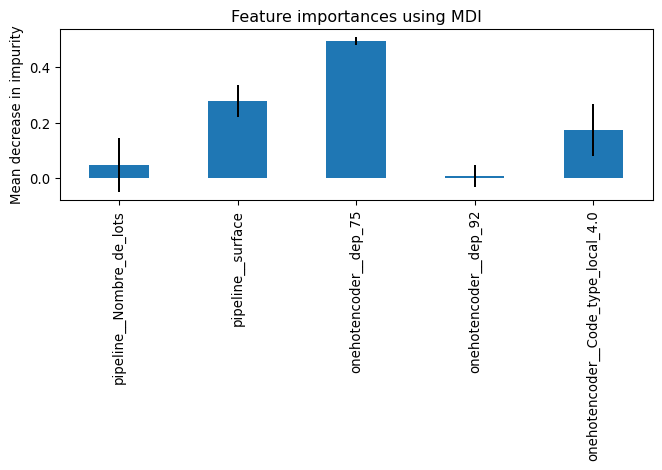

In [27]:
features_names = pipe[:-1].get_feature_names_out()
importances = pipe["randomforest"].feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in pipe["randomforest"].estimators_], axis=0
)

forest_importances = pd.DataFrame(importances, index=features_names, columns=["mdi"])
forest_importances["std"] = std

fig, ax = plt.subplots()
forest_importances.loc[forest_importances["mdi"] > 0, "mdi"].plot.bar(
    yerr=forest_importances.loc[forest_importances["mdi"] > 0, "std"], ax=ax
)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


<Axes: title={'center': 'Feature importances using MDI'}, ylabel='Mean decrease in impurity'>

Les statistiques obtenues par le biais de cette *variable importance*
sont un peu rudimentaires mais permettent déjà de comprendre
le problème de notre modèle.

On voit donc que deux de nos variables déterminantes sont des effets fixes
géographiques (qui servent à ajuster de la différence de prix entre
Paris et les Hauts de Seine et le reste de la France), une autre variable
est un effet fixe type de bien. Les deux variables qui pourraient introduire
de la variabilité, à savoir la surface et, dans une moindre mesure, le
nombre de lots, ont une importance moindre.

<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Note</h3>

Idéalement, on utiliserait `Yellowbrick` pour représenter l’importance des variables
Mais en l’état actuel du *pipeline* on a beaucoup de variables dont le poids
est nul qui viennent polluer la visualisation. Vous pouvez
consulter la
[documentation de `Yellowbrick` sur ce sujet](https://www.scikit-yb.org/en/latest/api/model_selection/importances.html)

</div>

In [29]:
compar = pd.DataFrame([y_test, pipe.predict(X_test)]).T
compar.columns = ["obs", "pred"]
compar["diff"] = compar.obs - compar.pred


Les prédictions peuvent nous suggérer également
qu’il y a un problème.

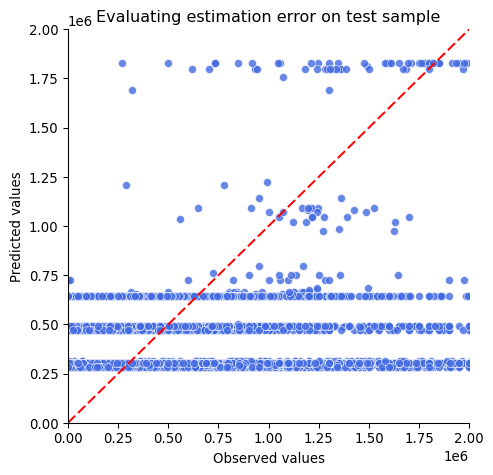

In [30]:
g = sns.relplot(data=compar, x="obs", y="pred", color="royalblue", alpha=0.8)
g.set(
    ylim=(0, 2e6),
    xlim=(0, 2e6),
    title="Evaluating estimation error on test sample",
    xlabel="Observed values",
    ylabel="Predicted values",
)
g.ax.axline(xy1=(0, 0), slope=1, color="red", dashes=(5, 2))


# 4. Restriction du champ du modèle

Mettre en oeuvre un bon modèle de prix au niveau France entière
est complexe. Nous allons donc nous restreindre au champ suivant:
les appartements dans Paris.

In [31]:
mutations_paris = mutations.drop(
    colonnes_surface.tolist()
    + ["Date mutation", "lprix"],  # ajouter "confinement" si données 2020
    axis="columns",
).copy()

mutations_paris = mutations_paris.loc[
    mutations_paris["Valeur fonciere"] < 5e6
]  # keep only values below 5 millions

mutations_paris.columns = mutations_paris.columns.str.replace(" ", "_")
mutations_paris = mutations_paris.dropna(subset=["dep", "Code_type_local", "month"])
mutations_paris = mutations_paris.loc[mutations_paris["dep"] == "75"]
mutations_paris = mutations_paris.loc[mutations_paris["Code_type_local"] == 2].drop(
    ["dep", "Code_type_local"], axis="columns"
)
mutations_paris.loc[mutations_paris["surface"] > 0]


27971 rows × 5 columns

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 4 : Pipeline plus simple</h3>

Reprendre les codes précédents et reconstruire notre *pipeline* sur
la nouvelle base en mettant en oeuvre une méthode de *boosting*
plutôt qu’une forêt aléatoire.

*La correction de cet exercice est apparente pour simplifier les prochaines étapes mais essayez de faire celui-ci de vous-même*.

</div>

A l’issue de cet exercice, vous devriez avoir des *MDI* proches
de celles-ci :

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split


mutations_paris = mutations.drop(
    colonnes_surface.tolist()
    + ["Date mutation", "lprix"],  # ajouter "confinement" si données 2020
    axis="columns",
).copy()

mutations_paris = mutations_paris.loc[
    mutations_paris["Valeur fonciere"] < 5e6
]  # keep only values below 5 millions

mutations_paris.columns = mutations_paris.columns.str.replace(" ", "_")
mutations_paris = mutations_paris.dropna(subset=["dep", "Code_type_local", "month"])
mutations_paris = mutations_paris.loc[mutations_paris["dep"] == "75"]
mutations_paris = mutations_paris.loc[mutations_paris["Code_type_local"] == 2].drop(
    ["dep", "Code_type_local", "Nombre_de_lots"], axis="columns"
)
mutations_paris.loc[mutations_paris["surface"] > 0]


numeric_features = mutations_paris.columns[
    ~mutations_paris.columns.isin(["month", "Valeur_fonciere"])
].tolist()
categorical_features = ["month"]

reg = GradientBoostingRegressor(random_state=0)

numeric_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
transformer = make_column_transformer(
    (numeric_pipeline, numeric_features),
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features),
)
pipe = Pipeline(steps=[("preprocessor", transformer), ("boosting", reg)])

X_train, X_test, y_train, y_test = train_test_split(
    mutations_paris.drop("Valeur_fonciere", axis=1),
    mutations_paris[["Valeur_fonciere"]].values.ravel(),
    test_size=0.2,
    random_state=123,
)

pipe.fit(X_train, y_train)

pd.DataFrame(
    pipe["boosting"].feature_importances_, index=pipe[:-1].get_feature_names_out()
)


# 5. Recherche des hyperparamètres optimaux avec une validation croisée

On détecte que le premier modèle n’est pas très bon et ne nous aidera
pas vraiment à évaluer de manière fiable l’appartement de nos rêves.

On va essayer de voir si notre modèle ne serait pas meilleur avec des
hyperparamètres plus adaptés. Après tout, nous avons choisi par défaut
la profondeur de l’arbre mais c’était un choix au doigt mouillé.

❓️ Quels sont les hyperparamètres qu’on peut essayer d’optimiser ?

In [33]:
pipe["boosting"].get_params()


{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Un [détour par la documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
nous aide à comprendre ceux sur lesquels on va jouer. Par exemple, il serait
absurde de jouer sur le paramètre `random_state` qui est la racine du générateur
pseudo-aléatoire.

In [34]:
X = pd.concat((X_train, X_test), axis=0)
Y = np.concatenate([y_train, y_test])


Nous allons nous contenter de jouer sur les paramètres:

-   `n_estimators`: Le nombre d’arbres de décision que notre forêt contient
-   `max_depth`: La profondeur de chaque arbre

Il existe plusieurs manières de faire de la validation croisée. Nous allons ici
utiliser la *grid search* qui consiste à estimer et tester le modèle sur chaque
combinaison d’une grille de paramètres et sélectionner le couple de valeurs
des hyperparamètres amenant à la meilleure prédiction. Par défaut, `scikit`
effectue une *5-fold cross validation*. Nous n’allons pas changer
ce comportement.

Comme expliqué précédemment, les paramètres s’appelent sous la forme
`<step>__<parameter_name>`

La validation croisée pouvant être très consommatrice de temps, nous
n’allons l’effectuer que sur un nombre réduit de valeurs de notre grille.
Il est possible de passer la liste des valeurs à passer au crible sous
forme de liste
(comme nous allons le proposer pour l’argument `max_depth` dans l’exercice ci-dessous) ou
sous forme d’`array` (comme nous allons le proposer pour l’argument `n_estimators`) ce qui est
souvent pratique pour générer un criblage d’un intervalle avec `np.linspace`.

<div class="alert alert-warning" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Hint </h3>

Les estimations sont, par défaut, menées de manière séquentielle (l’une après
l’autre). Nous sommes cependant face à un problème
*embarassingly parallel*.
Pour gagner en performance, il est recommandé d’utiliser l’argument
`n_jobs=-1`.

</div>

In [35]:
import numpy as np
from sklearn.model_selection import GridSearchCV

import time

start_time = time.time()
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    "boosting__n_estimators": np.linspace(5, 25, 5).astype(int),
    "boosting__max_depth": [2, 4],
}
grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train, y_train)

end_time = time.time()

print(f"Elapsed time : {int(end_time - start_time)} seconds")


In [36]:
grid_search


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
 ColumnTransformer(transformers=[('pipeline',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer()),
 ('standardscaler',
 StandardScaler())]),
 ['Nombre_pieces_principales',
 'surface']),
 ('onehotencoder',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False),
 ['month'])])),
 ('boosting',
 GradientBoostingRegressor(random_state=0))]),
 param_grid={'boosting__max_depth': [2, 4],
 'boosting__n_estimators': array([ 5, 10, 15, 20, 25])}) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.   GridSearchCV ? Documentation for GridSearchCV i Fitted GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
 ColumnTransformer(transformers=[('pipeline',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer()),
 ('standardscaler',
 StandardScaler())]),
 ['Nombre_pieces_principales',
 'surface']),
 ('onehotencoder',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False),
 ['month'])])),
 ('boosting',
 GradientBoostingRegressor(random_state=0))]),
 param_grid={'boosting__max_depth': [2, 4],
 'boosting__n_estimators': array([ 5, 10, 15, 20, 25])}) estimator: Pipeline Pipeline(steps=[('preprocessor',
 ColumnTransformer(transformers=[('pipeline',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer()),
 ('standardscaler',
 StandardScaler())]),
 ['Nombre_pieces_principales',
 'surface']),
 ('onehotencoder',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False),
 ['month'])])),
 ('boosting', GradientBoostingRegressor(random_state=0))])  preprocessor: ColumnTransformer ? Documentation for preprocessor: ColumnTransformer ColumnTransformer(transformers=[('pipeline',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer()),
 ('standardscaler',
 StandardScaler())]),
 ['Nombre_pieces_principales', 'surface']),
 ('onehotencoder',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False),
 ['month'])]) pipeline ['Nombre_pieces_principales', 'surface']  SimpleImputer ? Documentation for SimpleImputer SimpleImputer()  StandardScaler ? Documentation for StandardScaler StandardScaler() onehotencoder ['month']  OneHotEncoder ? Documentation for OneHotEncoder OneHotEncoder(handle_unknown='ignore', sparse_output=False)  GradientBoostingRegressor ? Documentation for GradientBoostingRegressor GradientBoostingRegressor(random_state=0)

In [37]:
grid_search.best_params_
grid_search.best_estimator_


Pipeline(steps=[('preprocessor',
 ColumnTransformer(transformers=[('pipeline',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer()),
 ('standardscaler',
 StandardScaler())]),
 ['Nombre_pieces_principales',
 'surface']),
 ('onehotencoder',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False),
 ['month'])])),
 ('boosting',
 GradientBoostingRegressor(max_depth=4, n_estimators=25,
 random_state=0))]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.   Pipeline ? Documentation for Pipeline i Fitted Pipeline(steps=[('preprocessor',
 ColumnTransformer(transformers=[('pipeline',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer()),
 ('standardscaler',
 StandardScaler())]),
 ['Nombre_pieces_principales',
 'surface']),
 ('onehotencoder',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False),
 ['month'])])),
 ('boosting',
 GradientBoostingRegressor(max_depth=4, n_estimators=25,
 random_state=0))])  preprocessor: ColumnTransformer ? Documentation for preprocessor: ColumnTransformer ColumnTransformer(transformers=[('pipeline',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer()),
 ('standardscaler',
 StandardScaler())]),
 ['Nombre_pieces_principales', 'surface']),
 ('onehotencoder',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False),
 ['month'])]) pipeline ['Nombre_pieces_principales', 'surface']  SimpleImputer ? Documentation for SimpleImputer SimpleImputer()  StandardScaler ? Documentation for StandardScaler StandardScaler() onehotencoder ['month']  OneHotEncoder ? Documentation for OneHotEncoder OneHotEncoder(handle_unknown='ignore', sparse_output=False)  GradientBoostingRegressor ? Documentation for GradientBoostingRegressor GradientBoostingRegressor(max_depth=4, n_estimators=25, random_state=0)

Toutes les performances sur les ensembles d’échantillons et de test sur la grille
d’hyperparamètres sont disponibles dans l’attribut:

In [38]:
perf_random_forest = pd.DataFrame(grid_search.cv_results_)


Regardons les résultats moyens pour chaque valeur des hyperparamètres:

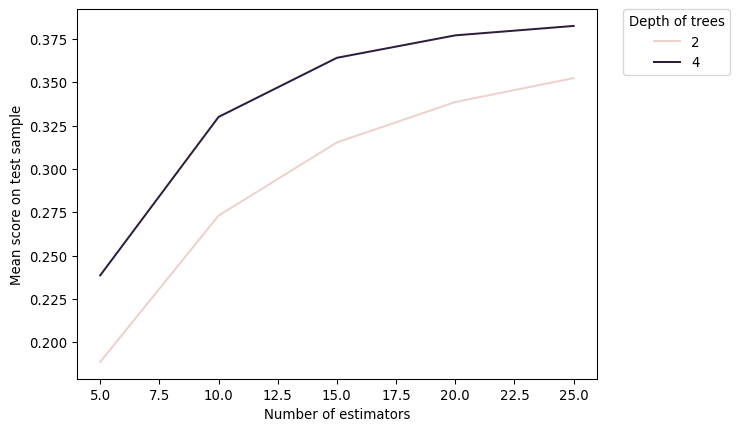

In [39]:
fig, ax = plt.subplots(1)
g = sns.lineplot(
    data=perf_random_forest,
    ax=ax,
    x="param_boosting__n_estimators",
    y="mean_test_score",
    hue="param_boosting__max_depth",
)
g.set(xlabel="Number of estimators", ylabel="Mean score on test sample")
g
plt.legend(
    bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Depth of trees"
)


Globalement, à profondeur d’arbre donnée, le nombre d’arbres affecte
la performance. Changer la profondeur de l’arbre améliore la
performance de manière plus marquée.

Maintenant, il nous reste à re-entraîner le modèle avec ces nouveaux
paramètres sur l’ensemble du jeu de *train* et l’évaluer sur l’ensemble
du jeu de *test* :

In [40]:
pipe_optimal = grid_search.best_estimator_
pipe_optimal.fit(X_train, y_train)

compar = pd.DataFrame([y_test, pipe_optimal.predict(X_test)]).T
compar.columns = ["obs", "pred"]
compar["diff"] = compar.obs - compar.pred


On obtient le RMSE suivant :

In [41]:
print(
    "Le RMSE sur le jeu de test est {:,}".format(
        int(np.sqrt(mean_squared_error(y_test, pipe_optimal.predict(X_test))))
    )
)


Le RMSE sur le jeu de test est 562,317

Et si on regarde la qualité en prédiction:

On obtient plus de variance dans la prédiction, c’est déjà un peu mieux.
Cependant, cela reste décevant pour plusieurs raisons:

-   nous n’avons pas fait d’étape de sélection de variable
-   nous n’avons pas chercher à déterminer si la variable à prédire la plus
    pertinente était le prix ou une transformation de celle-ci
    (par exemple le prix au $m^2$)

# 6. Prochaine étape

Nous avons un modèle certes perfectible mais fonctionnel.
La question qui se pose maintenant c’est d’essayer d’en faire
quelque chose au service des utilisateurs. Cela nous amène vers
la question de la **mise en production**.

Ceci est l’objet du prochain chapitre. Il s’agira d’une version introductive
des enjeux évoqués dans le cadre du cours de
3e année de [mise en production de projets de *data science*](https://ensae-reproductibilite.github.io/website/).

# 7. Références

Breiman, Leo. 1996. « Bagging predictors ». *Machine learning* 24: 123‑40.

———. 2001. « Random forests ». *Machine learning* 45: 5‑32.